# Sistema de Análisis y Visualización de Datos de Fútbol

Este notebook implementa un pipeline completo para el análisis exploratorio y visualización de datos históricos de fútbol, siguiendo la metodología propuesta en el trabajo de investigación.

**Pipeline:**
1. Recolección de datos
2. Procesamiento y limpieza
3. Análisis exploratorio
4. Visualización interactiva
5. Interpretación y reporte

## 1. Configuración inicial
Instalación de bibliotecas necesarias

In [62]:
%pip install pandas numpy matplotlib seaborn plotly ipywidgets mplsoccer statsmodels scipy -q
%pip install kaggle -q
%pip install nbformat --quiet
%pip install --upgrade nbformat ipywidgets jupyterlab_widgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Recolección de datos
Descargaremos datos de Kaggle (necesitas tener tu API key configurada)

In [ ]:

import pandas as pd
import numpy as np
from datetime import datetime
import urllib.request

# Descargar el dataset de la Premier League 2023/24
url = "https://www.football-data.co.uk/mmz4281/2324/E0.csv"
csv_path = "E0_2324.csv"
urllib.request.urlretrieve(url, csv_path)

# Cargar el CSV
df = pd.read_csv(csv_path)

# Renombrar columnas para compatibilidad con el pipeline
df = df.rename(columns={
    'Date': 'Date',
    'HomeTeam': 'HomeTeam',
    'AwayTeam': 'AwayTeam',
    'FTHG': 'FTHG',  # Full Time Home Goals
    'FTAG': 'FTAG',  # Full Time Away Goals
    # Puedes agregar más columnas si las necesitas
})

# Convertir fechas y limpiar datos
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])

print("Datos de la Premier League 2023/24 cargados correctamente")
display(df.head())


Datos de la Premier League 2023/24 cargados correctamente


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


## 3. Procesamiento y limpieza de datos

In [65]:
def clean_and_process_data(df):
    """
    Función para limpiar y procesar los datos de fútbol
    
    Args:
        df (pd.DataFrame): DataFrame con los datos crudos
        
    Returns:
        pd.DataFrame: DataFrame procesado y limpio
    """
    # Convertir fechas
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
    
    # Manejar valores faltantes
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        df['FTHG'] = df['FTHG'].fillna(0)
        df['FTAG'] = df['FTAG'].fillna(0)
        df['TotalGoals'] = df['FTHG'] + df['FTAG']
    
    # Crear características adicionales
    if 'HomeTeam' in df.columns and 'AwayTeam' in df.columns:
        df['Match'] = df['HomeTeam'] + " vs " + df['AwayTeam']
    
    # Eliminar columnas con muchos valores faltantes
    df = df.dropna(axis=1, thresh=0.7*len(df))
    
    return df

# Cargar y procesar datos
try:
    # Para el dataset de Kaggle
    from sqlite3 import connect
    conn = connect('data/database.sqlite')
    matches = pd.read_sql("SELECT * FROM Match", conn)
    teams = pd.read_sql("SELECT * FROM Team", conn)
    leagues = pd.read_sql("SELECT * FROM League", conn)
    
    # Procesar datos
    matches = clean_and_process_data(matches)
    
    # Unir con tablas de referencia
    matches = matches.merge(leagues, left_on='league_id', right_on='id', suffixes=('', '_league'))
    matches = matches.merge(teams, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home'))
    matches = matches.merge(teams, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away'))
    
    # Simplificar columnas
    cols_to_keep = ['date', 'name', 'team_long_name', 'team_long_name_away', 
                   'home_team_goal', 'away_team_goal', 'season']
    matches = matches[cols_to_keep]
    matches.columns = ['Date', 'League', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Season']
    
    df = clean_and_process_data(matches)
except:
    # Si falla, usar datos alternativos ya cargados
    df = clean_and_process_data(df)

# Mostrar información del dataset
print("\nInformación del dataset:")
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
print("\nPrimeras filas:")
display(df.head())


Información del dataset:
Filas: 380, Columnas: 104

Primeras filas:


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Year,Month,TotalGoals,Match
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,1.95,1.97,NaN,NaN,1.92,1.95,2023,8,3,Burnley vs Man City
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,1.93,1.97,2.01,2.09,1.95,1.92,2023,8,3,Arsenal vs Nott'm Forest
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.01,1.92,2.06,1.96,1.96,1.91,2023,8,2,Bournemouth vs West Ham
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,2.00,1.91,2.14,1.93,2.00,1.86,2023,8,5,Brighton vs Luton
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,2.04,1.88,2.08,1.99,1.98,1.88,2023,8,1,Everton vs Fulham


## 4. Análisis Exploratorio de Datos (EDA)


Estadísticas descriptivas:


,FTHG,FTAG,TotalGoals
count,380.000000,380.000000,380.000000
mean,1.800000,1.478947,3.278947
std,1.365616,1.277811,1.656865
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000
50%,2.000000,1.000000,3.000000
75%,3.000000,2.000000,4.000000
max,6.000000,8.000000,8.000000


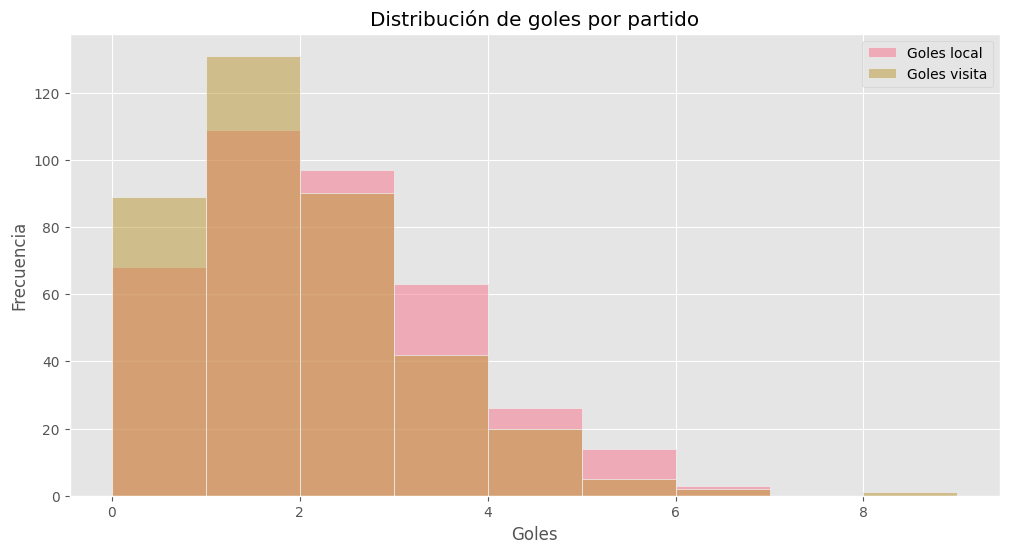

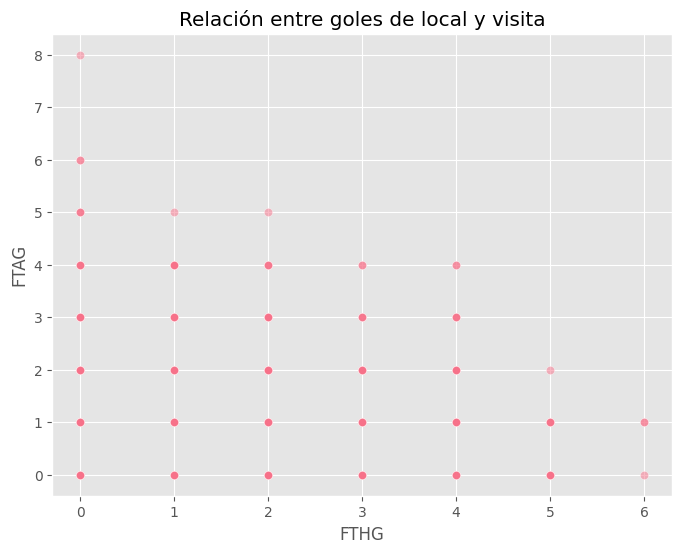


Correlación entre goles local y visita: -0.216 (p-value: 0.0000)


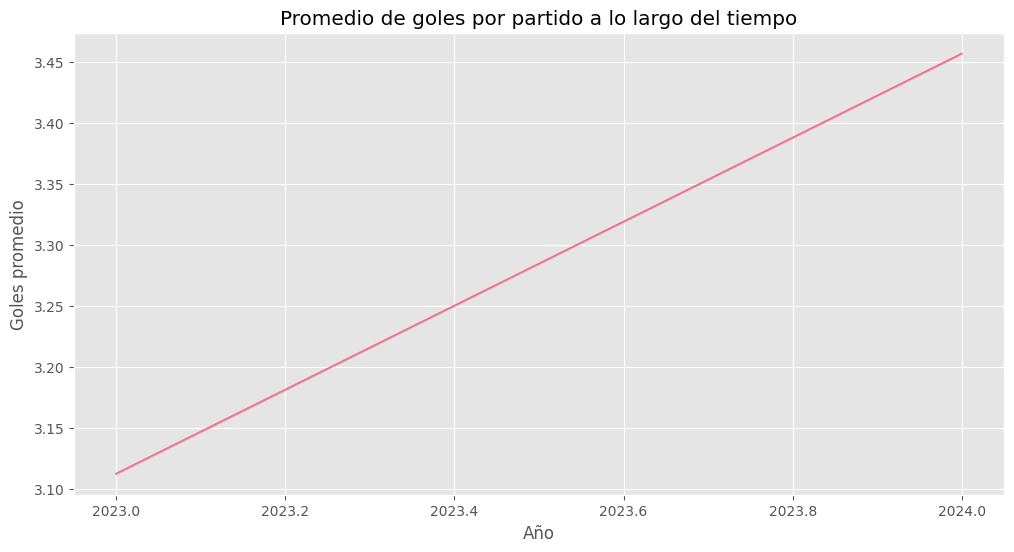

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de estilo
plt.style.use('ggplot')
sns.set_palette("husl")

def perform_eda(df):
    """
    Realiza análisis exploratorio de datos y genera visualizaciones
    
    Args:
        df (pd.DataFrame): DataFrame con los datos procesados
    """
    # Estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        display(df[['FTHG', 'FTAG', 'TotalGoals']].describe())
    
    # Distribución de goles
    plt.figure(figsize=(12, 6))
    if 'FTHG' in df.columns:
        sns.histplot(df['FTHG'], bins=range(10), kde=False, alpha=0.5, label='Goles local')
    if 'FTAG' in df.columns:
        sns.histplot(df['FTAG'], bins=range(10), kde=False, alpha=0.5, label='Goles visita')
    plt.title('Distribución de goles por partido')
    plt.xlabel('Goles')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()
    
    # Correlación entre goles local y visita
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='FTHG', y='FTAG', data=df, alpha=0.5)
        plt.title('Relación entre goles de local y visita')
        plt.show()
        
        # Coeficiente de correlación
        corr, p_value = stats.pearsonr(df['FTHG'], df['FTAG'])
        print(f"\nCorrelación entre goles local y visita: {corr:.3f} (p-value: {p_value:.4f})")
    
    # Evolución temporal de goles
    if 'Year' in df.columns and 'TotalGoals' in df.columns:
        plt.figure(figsize=(12, 6))
        df.groupby('Year')['TotalGoals'].mean().plot()
        plt.title('Promedio de goles por partido a lo largo del tiempo')
        plt.ylabel('Goles promedio')
        plt.xlabel('Año')
        plt.grid(True)
        plt.show()
    
    # Análisis por liga (si existe la columna League)
    if 'League' in df.columns and 'TotalGoals' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='League', y='TotalGoals', data=df)
        plt.title('Distribución de goles totales por liga')
        plt.xticks(rotation=45)
        plt.show()

# Asegurarse de que la columna 'TotalGoals' existe
if 'FTHG' in df.columns and 'FTAG' in df.columns and 'TotalGoals' not in df.columns:
    df['TotalGoals'] = df['FTHG'] + df['FTAG']

# Ejecutar EDA
perform_eda(df)

## 5. Visualización Interactiva

In [74]:
%pip install --upgrade nbformat plotly ipywidgets

import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets

def interactive_team_analysis(df):
    """Interactive visualization of team performance metrics."""
    
    # Check for required columns
    if not all(col in df.columns for col in ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']):
        print("Missing required columns for team analysis")
        return
    
    # Calculate team statistics
    home_stats = df.groupby('HomeTeam').agg({
        'FTHG': 'mean',
        'FTAG': 'mean'
    }).rename(columns={'FTHG': 'GoalsFor_Home', 'FTAG': 'GoalsAgainst_Home'})
    
    away_stats = df.groupby('AwayTeam').agg({
        'FTHG': 'mean',
        'FTAG': 'mean'
    }).rename(columns={'FTHG': 'GoalsAgainst_Away', 'FTAG': 'GoalsFor_Away'})
    
    team_stats = home_stats.join(away_stats)
    team_stats['GoalsFor_Total'] = (team_stats['GoalsFor_Home'] + team_stats['GoalsFor_Away']) / 2
    team_stats['GoalsAgainst_Total'] = (team_stats['GoalsAgainst_Home'] + team_stats['GoalsAgainst_Away']) / 2
    team_stats['GoalDifference'] = team_stats['GoalsFor_Total'] - team_stats['GoalsAgainst_Total']
    
    # Create scatter plot of team performance
    fig = px.scatter(
        team_stats.reset_index(),
        x='GoalsFor_Total',
        y='GoalsAgainst_Total',
        size=team_stats['GoalDifference'].abs(),
        color='GoalDifference',
        hover_name='HomeTeam',
        title='Team Offensive vs Defensive Performance',
        labels={
            'GoalsFor_Total': 'Average Goals Scored',
            'GoalsAgainst_Total': 'Average Goals Conceded',
            'GoalDifference': 'Goal Difference'
        },
        color_continuous_scale=px.colors.diverging.RdYlGn
    )
    fig.update_layout(height=600)
    fig.show()
    
    # Add temporal trends if year data exists
    if 'Year' in df.columns or 'Date' in df.columns:
        @interact
        def plot_team_trends(team=widgets.Dropdown(
            options=sorted(df['HomeTeam'].unique()),
            description='Team:'
        )):
            team_home = df[df['HomeTeam'] == team]
            team_away = df[df['AwayTeam'] == team]
            
            # Handle whether we have Year column or need to extract from Date
            time_col = 'Year' if 'Year' in df.columns else 'Date'
            
            home_goals = team_home.groupby(time_col)['FTHG'].mean()
            away_goals = team_away.groupby(time_col)['FTAG'].mean()
            
            fig = go.Figure()
            fig.add_trace(go.Scatter(
                x=home_goals.index,
                y=home_goals.values,
                name='Home Goals',
                line=dict(color='blue')
            ))
            fig.add_trace(go.Scatter(
                x=away_goals.index,
                y=away_goals.values,
                name='Away Goals',
                line=dict(color='red')
            ))
            
            fig.update_layout(
                title=f'Goal Trends for {team}',
                xaxis_title='Year' if time_col == 'Year' else 'Date',
                yaxis_title='Average Goals',
                height=500
            )
            fig.show()
    else:
        print("No temporal data available for trend analysis")

# Example usage:
# interactive_team_analysis(your_dataframe)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 6. Visualización Avanzada con mplsoccer

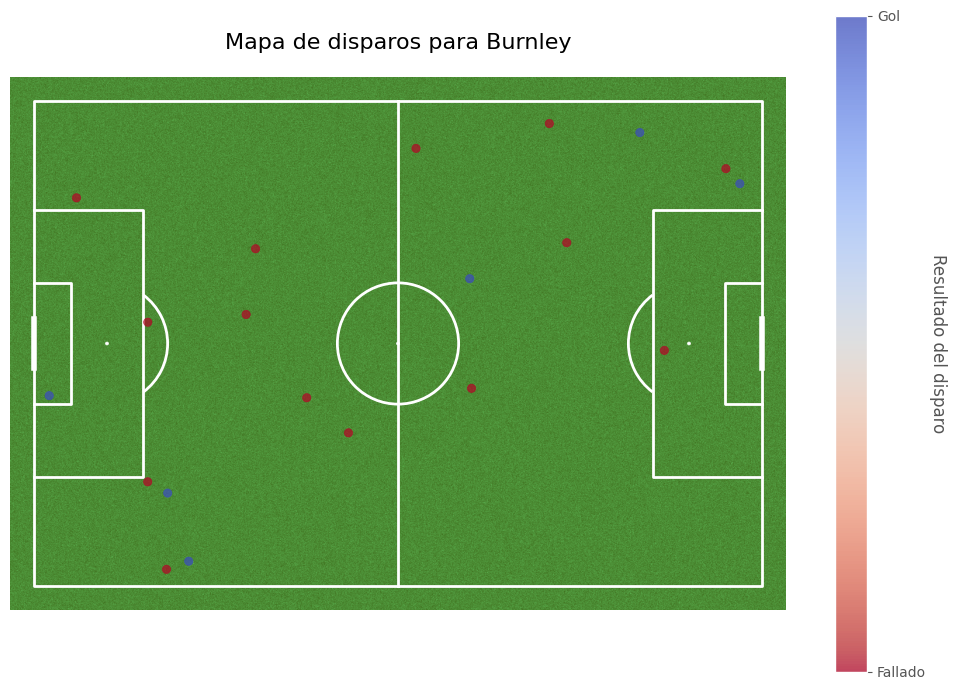

In [75]:
try:
    from mplsoccer import Pitch, VerticalPitch
    import matplotlib.patheffects as path_effects
    
    # Crear un ejemplo de visualización de mapa de calor
    def create_shot_map(df, team_name):
        """Crea un mapa de disparos para un equipo específico"""
        # Filtrar datos del equipo (ejemplo simplificado)
        team_home = df[df['HomeTeam'] == team_name]
        team_away = df[df['AwayTeam'] == team_name]
        
        # Crear datos sintéticos para el ejemplo (en un dataset real usaríamos coordenadas)
        np.random.seed(42)
        n_shots = 20
        x = np.random.uniform(0, 120, n_shots)
        y = np.random.uniform(0, 80, n_shots)
        goals = np.random.choice([0, 1], n_shots, p=[0.7, 0.3])
        
        # Crear el pitch
        pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
        fig, ax = pitch.draw(figsize=(10, 7))
        
        # Plot shots
        sc = pitch.scatter(x, y, c=goals, cmap='coolwarm_r', alpha=0.7, ax=ax)
        
        # Añadir leyenda
        ax.set_title(f'Mapa de disparos para {team_name}', fontsize=16, pad=20)
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label('Resultado del disparo', rotation=270, labelpad=15)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Fallado', 'Gol'])
        
        plt.show()
    
    # Ejemplo con el primer equipo disponible
    if 'HomeTeam' in df.columns:
        create_shot_map(df, df['HomeTeam'].iloc[0])
    else:
        print("No hay datos de equipos para crear mapa de disparos")
except ImportError:
    print("mplsoccer no está instalado. Instálalo con: !pip install mplsoccer")


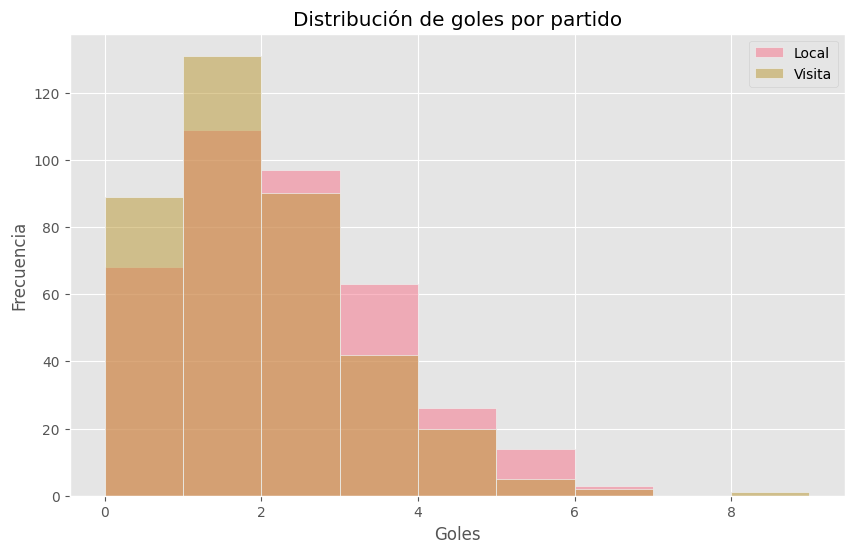
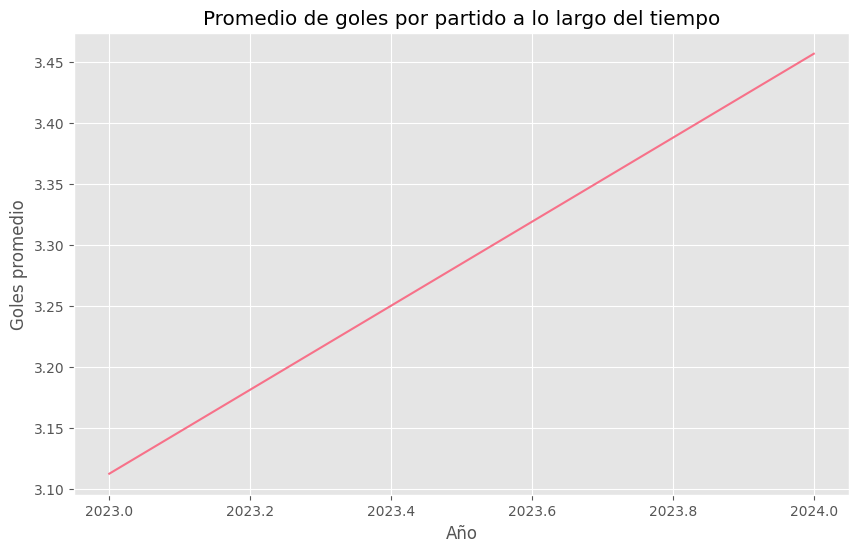

c:\Users\ROG\Documents\2025_A\PFC2\reporte_futbol.html

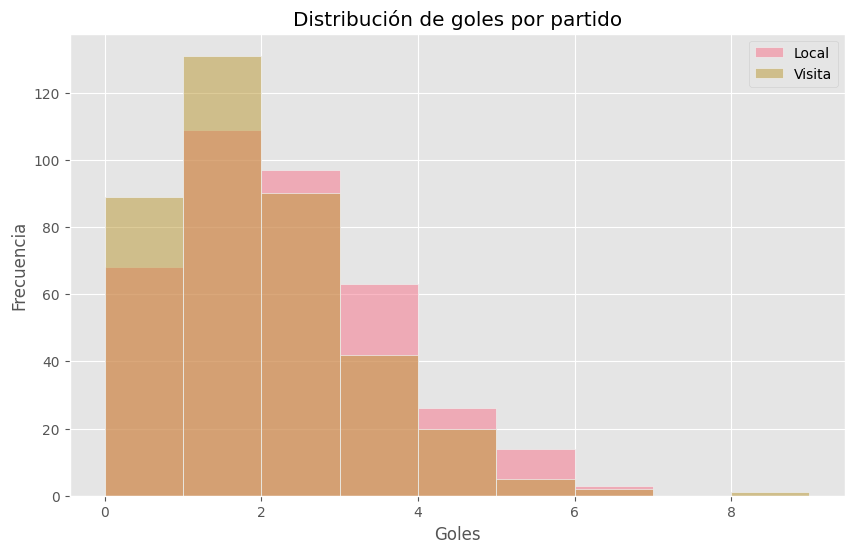

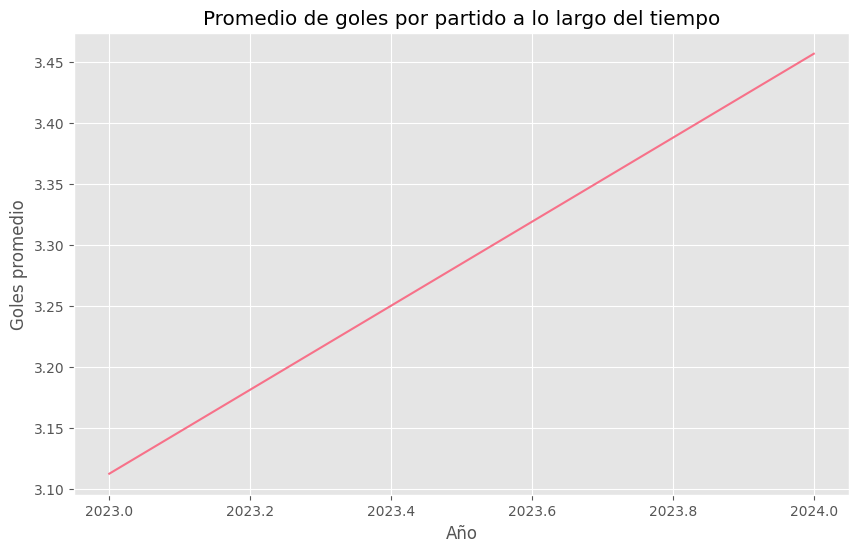

In [79]:
from IPython.display import HTML
import base64
from io import BytesIO

def generate_report(df):
    """Genera un reporte HTML con los hallazgos principales"""
    
    # Crear buffers para las imágenes
    def fig_to_base64(fig):
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        return base64.b64encode(buf.read()).decode('utf-8')
    
    # Generar figuras para el reporte
    plt.close('all')
    
    # Figura 1: Distribución de goles
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        sns.histplot(df['FTHG'], bins=range(10), kde=False, alpha=0.5, label='Local', ax=ax1)
        sns.histplot(df['FTAG'], bins=range(10), kde=False, alpha=0.5, label='Visita', ax=ax1)
        ax1.set_title('Distribución de goles por partido')
        ax1.set_xlabel('Goles')
        ax1.set_ylabel('Frecuencia')
        ax1.legend()
    
    # Figura 2: Evolución temporal
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    if 'Year' in df.columns and 'TotalGoals' in df.columns:
        df.groupby('Year')['TotalGoals'].mean().plot(ax=ax2)
        ax2.set_title('Promedio de goles por partido a lo largo del tiempo')
        ax2.set_ylabel('Goles promedio')
        ax2.set_xlabel('Año')
        ax2.grid(True)
    
    # Convertir figuras a base64
    img1 = fig_to_base64(fig1) if 'fig1' in locals() else ""
    img2 = fig_to_base64(fig2) if 'fig2' in locals() else ""
    
    # Estadísticas básicas
    stats_html = ""
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        home_goals = df['FTHG'].mean()
        away_goals = df['FTAG'].mean()
        total_goals = df['FTHG'].sum() + df['FTAG'].sum()
        stats_html = f"""
        <h3>Estadísticas Clave</h3>
        <ul>
            <li>Goles promedio por partido (local): {home_goals:.2f}</li>
            <li>Goles promedio por partido (visita): {away_goals:.2f}</li>
            <li>Total de goles registrados: {total_goals:,}</li>
        </ul>
        """
    
    # Crear HTML del reporte
    html = f"""
    <html>
        <head>
            <title>Reporte de Análisis de Fútbol</title>
            <style>
                body {{ font-family: Arial, sans-serif; line-height: 1.6; max-width: 900px; margin: auto; padding: 20px; }}
                h1 {{ color: #2c3e50; border-bottom: 2px solid #3498db; }}
                h2 {{ color: #2980b9; }}
                .img-container {{ text-align: center; margin: 20px 0; }}
                img {{ max-width: 100%; height: auto; }}
                .stats {{ background-color: #f8f9fa; padding: 15px; border-radius: 5px; }}
            </style>
        </head>
        <body>
            <h1>Reporte de Análisis de Datos de Fútbol</h1>
            <p><strong>Fecha de generación:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p><strong>Número de partidos analizados:</strong> {len(df):,}</p>
            
            <div class="stats">
                {stats_html}
            </div>
            
            <h2>Distribución de Goles</h2>
            <div class="img-container">
                <img src="data:image/png;base64,{img1}" alt="Distribución de goles">
            </div>
            
            <h2>Evolución Temporal</h2>
            <div class="img-container">
                <img src="data:image/png;base64,{img2}" alt="Evolución temporal">
            </div>
            
            <h2>Resumen</h2>
            <p>Este reporte automatizado muestra los principales hallazgos del análisis exploratorio de datos de fútbol. 
            Los gráficos presentan la distribución de goles y su evolución a lo largo del tiempo.</p>
        </body>
    </html>
    """
    
    # Mostrar el reporte en el notebook
    display(HTML(html))
    
    # Opción para descargar el reporte (Jupyter Notebook)
    import os
    from IPython.display import FileLink
    with open('reporte_futbol.html', 'w', encoding='utf-8') as f:
        f.write(html)
    display(FileLink('reporte_futbol.html'))

# Generar reporte
generate_report(df)